In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp

# Get Overall Posterior
## $P(\theta|X_{1},...X_{n}) = $${{P(\theta)}^{1-n}\Pi_{i}[P(\theta|X_{i})]} \over {\int{{P(\theta)}^{1-n}}\Pi_{i}[P(\theta|X_{i})]d\theta}$

In [5]:
# Get grid of log posterior values for x (observation)
def get_grid(posterior, x, n, ϵ):
    # Explored space
    s = np.linspace(prior_min[0], prior_max[0], n)
    m = np.linspace(prior_min[1], prior_max[1], n)
    p = np.linspace(prior_min[2], prior_max[2], n)
    
    # Change to MCMC posterior to sample more efficiently
    potential_fn = posterior.potential_fn
    potential_fn.set_x(x)
    posterior_mcmc = MCMCPosterior(potential_fn, proposal = prior)
    
    # Create empty grid
    grd = torch.tensor([[[[s_,m_,p_,0] for s_ in s] for m_ in m] for p_ in p], dtype=torch.float32).reshape(n**3,4)
    # Fill it with posterior probability (potential = log_prob for MCMC posterior)
    grd[:,3] = posterior_mcmc.potential(x=x,theta=grd[:,0:3])
    grd[:,3] = grd[:,3].apply_(lambda x: max(ϵ,x))
    return grd
    
# Estimating Overall Posterior for many observations
def get_overall_posterior(prior,posterior,line,n,ϵ):
    x = pd.read_csv(f'empirical_data/clean/{line}.csv', index_col=0)
    r = len(x)
    
    # get probs for first
    rim = get_grid(posterior, x.iloc[0,:], n,ϵ)
    prod_df = pd.DataFrame(columns = ['log_s','log_m','log_p'] + list(x.index)+['sum_logs'], index=[i for i in range(len(rim))])
    prod_df.iloc[:,0:3] = rim[:,0:3]
    prod_df.iloc[:,3] = rim[:,3]
    # insert other replicates to df
    for i in range(1,len(x)):
        x_0 = x.iloc[i,:]
        prod_df.iloc[:,3+i] = get_grid(posterior,x_0,n,ϵ)[:,3]
    # Column of sum of log-posteriors
    prod_df.loc[:,'sum_logs'] = prod_df.loc[:,list(x.index)].sum(axis=1)
    
    # Calculate constants for the integral
    lens = np.array([float(prior.base_dist.high[i])-float(prior.base_dist.low[i]) for i in range(3)]) # Prior dimensions
    A = np.prod(lens) # Prior volume
    dt = A / (n**3) # granularity

    # Obtain C using integral (approximated by Riemann sum)

    # log(integrand) = log(product of posteriors * prior^(1-n) * dt)
    prod_df['adj_sum_logs'] = prod_df['sum_logs'] + np.log(dt) + np.log((1/A)**(1-r))

    # Riemann sum (minus -> inverse)
    log_C = -1*logsumexp(prod_df['adj_sum_logs'])

    # Overall Posterior
    prod_df['log_overall_posterior'] = prod_df['sum_logs']+np.log((1/A)**(1-r))+log_C

    # Dump to csv
    prod_df.to_csv(f'overall_posteriors/{line}_overall_posterior.csv')
    
    return prod_df


## Each genotype's overall Maximum A-Posteriori

In [5]:
%%time

prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))

posterior = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))

for line in ['wt','ltr','ars','all']:
    prod_df = get_overall_posterior(prior,posterior,line,n=300,ϵ=-200)
    print(prod_df.iloc[prod_df['log_overall_posterior'].idxmax(), [0,1,2,-1]])

log_s                    -0.83612
log_m                   -3.939799
log_p                   -3.324415
log_overall_posterior    12.94751
Name: 21025074, dtype: object
log_s                    -0.735786
log_m                    -4.842809
log_p                    -4.327759
log_overall_posterior    12.490112
Name: 16508889, dtype: object
log_s                    -0.749164
log_m                    -5.996655
log_p                    -5.812709
log_overall_posterior    11.775146
Name: 9828187, dtype: object
log_s                    -0.896321
log_m                    -4.993311
log_p                    -5.311037
log_overall_posterior    11.947021
Name: 12096165, dtype: object
CPU times: user 2h 49min 8s, sys: 2h 48min 15s, total: 5h 37min 24s
Wall time: 33min 9s


### Marginal Posterior

Text(0, 0.5, '$ln(Density)$')

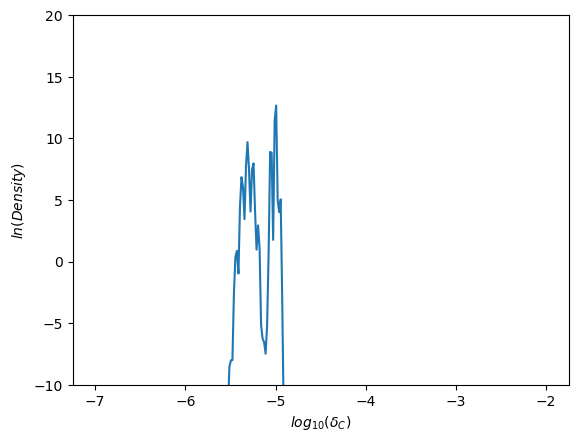

In [4]:
# Marginal posterior of mutation rate - all
# Using a pre-saved grid of n=400
# prod_df = pd.read_csv('overall_posteriors/all_overall_posterior.csv', index_col=0)
marg_m = prod_df.groupby('log_m')['log_overall_posterior'].apply(lambda x: logsumexp(x))
plt.plot(prod_df['log_m'].unique(),marg_m)
plt.ylim(-10,20)
plt.xlabel('$log_{10}({δ_C})$')
plt.ylabel('$ln(Density)$')

# Overall Posterior Validation

## Predictive Checks - Simulate Overall Posterior MAP and compare to empirical observations

log_s   -0.896321
log_m   -4.993311
log_p   -5.311037
Name: 12096165, dtype: float64


(-0.05, 1.05)

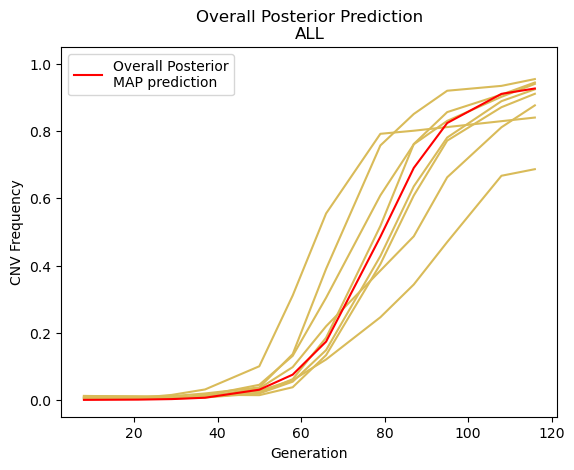

In [4]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF

# Model (simulator)
reps = 1
generation = pd.read_csv('Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 3.3e8

def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
    return states

# Plot Overall Posterior prediction for WT
# Get data
wt_df = pd.read_csv(f'empirical_data/clean/{line}.csv', index_col=0)
for i in range(len(wt_df)):
    plt.plot(generation.tolist(), wt_df.iloc[i,:], color="#D9BB59")

# Overall MAP
overall_map = prod_df.iloc[prod_df['log_overall_posterior'].idxmax(), 0:3]
print(overall_map)
params = torch.tensor(list(overall_map), dtype=torch.float64)
x = CNVsimulator(params).T
plt.plot(generation.tolist(),x, label = 'Overall Posterior\nMAP prediction', color='red')

# Plotting
plt.legend()
# plt.title('Overall Posterior Prediction\nLTR+ARS (all) KO')
plt.title(f'Overall Posterior Prediction\n{line.upper()}')

plt.xlabel('Generation')
plt.ylabel('CNV Frequency')
# plt.title(f'log(s) = {float(params[0])}, log(δ) = {float(params[1])}')
plt.ylim(-0.05,1.05)

## Validate that we don't just choose the highest peak of a single posterior

In [5]:
prod_df.sort_values(by='log_overall_posterior',ascending=False).iloc[0:10,:]

,log_s,log_m,log_p,gap1_all_1,gap1_all_2,gap1_all_3,gap1_all_4,gap1_all_5,gap1_all_6,gap1_all_7,gap1_all_8,sum_logs,adj_sum_logs,log_overall_posterior
12096165,-0.896321,-4.993311,-5.311037,-200.0,-200.0,-200.0,-28.217575,-200.0,-113.832570,-27.547176,-200.0,-1169.5974,-1153.9540,11.946899
12186165,-0.896321,-4.993311,-5.290970,-200.0,-200.0,-200.0,-26.899730,-200.0,-117.208050,-26.052511,-200.0,-1170.1603,-1154.5168,11.384033
12006165,-0.896321,-4.993311,-5.331104,-200.0,-200.0,-200.0,-29.696281,-200.0,-111.557430,-29.322910,-200.0,-1170.5767,-1154.9332,10.967651
12005865,-0.896321,-5.010034,-5.331104,-200.0,-200.0,-200.0,-16.459790,-200.0,-137.174600,-17.359745,-200.0,-1170.9941,-1155.3507,10.550171
12095865,-0.896321,-5.010034,-5.311037,-200.0,-200.0,-200.0,-15.345463,-200.0,-140.109830,-15.857769,-200.0,-1171.3131,-1155.6697,10.231201
11915865,-0.896321,-5.010034,-5.351171,-200.0,-200.0,-200.0,-17.677525,-200.0,-135.281220,-18.731102,-200.0,-1171.6898,-1156.0464,9.854492
11640471,-0.856187,-5.311037,-5.411371,-200.0,-200.0,-200.0,-44.073704,-200.0,-76.446270,-51.361656,-200.0,-1171.8816,-1156.2382,9.662720
11916165,-0.896321,-4.993311,-5.351171,-200.0,-200.0,-200.0,-31.327599,-200.0,-110.153090,-31.142511,-200.0,-1172.6232,-1156.9797,8.921143
12276165,-0.896321,-4.993311,-5.270903,-200.0,-200.0,-200.0,-25.756710,-200.0,-121.887764,-25.214441,-200.0,-1172.8589,-1157.2155,8.685425
11825865,-0.896321,-5.010034,-5.371237,-200.0,-200.0,-200.0,-18.995750,-200.0,-134.202530,-19.869890,-200.0,-1173.0681,-1157.4247,8.476196


In [8]:
lines = ['wt','ltr','ars','all']

map_df = pd.DataFrame(index = lines, columns = ['log_prob','log(s_cnv)','log(m_cnv)','log(p_0)'])
for line in lines:
    prod_df = pd.read_csv(f'overall_posteriors/{line}_overall_posterior.csv', index_col=0)
    overall_map = prod_df.iloc[prod_df['log_overall_posterior'].idxmax(), 0:3]
    map_log_prob = prod_df.iloc[prod_df['log_overall_posterior'].idxmax(), len(prod_df.columns)-1]
    map_df.loc[line,:] = [map_log_prob] + list(overall_map)
    
map_df.to_csv('maps/overall_maps_chuong.csv')
map_df

log_s                     -0.836120
log_m                     -3.939799
log_p                     -3.324415
gap1_1                   -29.586160
gap1_2                   -81.794050
gap1_3                  -250.000000
gap1_4                  -250.000000
gap1_5                  -250.000000
sum_logs                -861.380250
adj_sum_logs            -858.019900
log_overall_posterior     12.947510
Name: 21025074, dtype: float64
log_s                      -0.735786
log_m                      -4.842809
log_p                      -4.327759
gap1_ltr_1               -250.000000
gap1_ltr_3                -21.121588
gap1_ltr_4               -250.000000
gap1_ltr_5               -250.000000
gap1_ltr_6                -10.128077
gap1_ltr_7                -11.375545
gap1_ltr_8               -250.000000
sum_logs                -1042.625200
adj_sum_logs            -1031.076200
log_overall_posterior      12.490112
Name: 16508889, dtype: float64
log_s                      -0.749164
log_m                   

,log_prob,log(s_cnv),log(m_cnv),log(p_0)
wt,12.94751,-0.83612,-3.939799,-3.324415
ltr,12.490112,-0.735786,-4.842809,-4.327759
ars,11.775146,-0.749164,-5.996655,-5.812709
all,11.947021,-0.896321,-4.993311,-5.311037


# Sensitivity to $\epsilon$

log_s   -0.767677
log_m   -4.323232
log_p   -3.818182
Name: 695361, dtype: object
log_s   -0.767677
log_m   -4.323232
log_p   -3.818182
Name: 695361, dtype: object
log_s   -0.767677
log_m   -4.323232
log_p   -3.818182
Name: 695361, dtype: object
log_s   -0.828283
log_m   -3.969697
log_p   -3.393939
Name: 766058, dtype: object
log_s   -0.828283
log_m   -3.969697
log_p   -3.393939
Name: 766058, dtype: object
log_s   -0.828283
log_m   -3.969697
log_p   -3.393939
Name: 766058, dtype: object
log_s   -0.747475
log_m   -4.777778
log_p   -4.242424
Name: 624462, dtype: object
log_s   -0.747475
log_m   -4.777778
log_p   -4.242424
Name: 624462, dtype: object
log_s   -0.747475
log_m   -4.777778
log_p   -4.242424
Name: 624462, dtype: object
log_s   -0.747475
log_m   -4.777778
log_p   -4.242424
Name: 624462, dtype: object
log_s   -0.747475
log_m   -4.777778
log_p   -4.242424
Name: 624462, dtype: object
log_s   -0.606061
log_m   -5.737374
log_p   -5.515152
Name: 412569, dtype: object
log_s   -0.88888

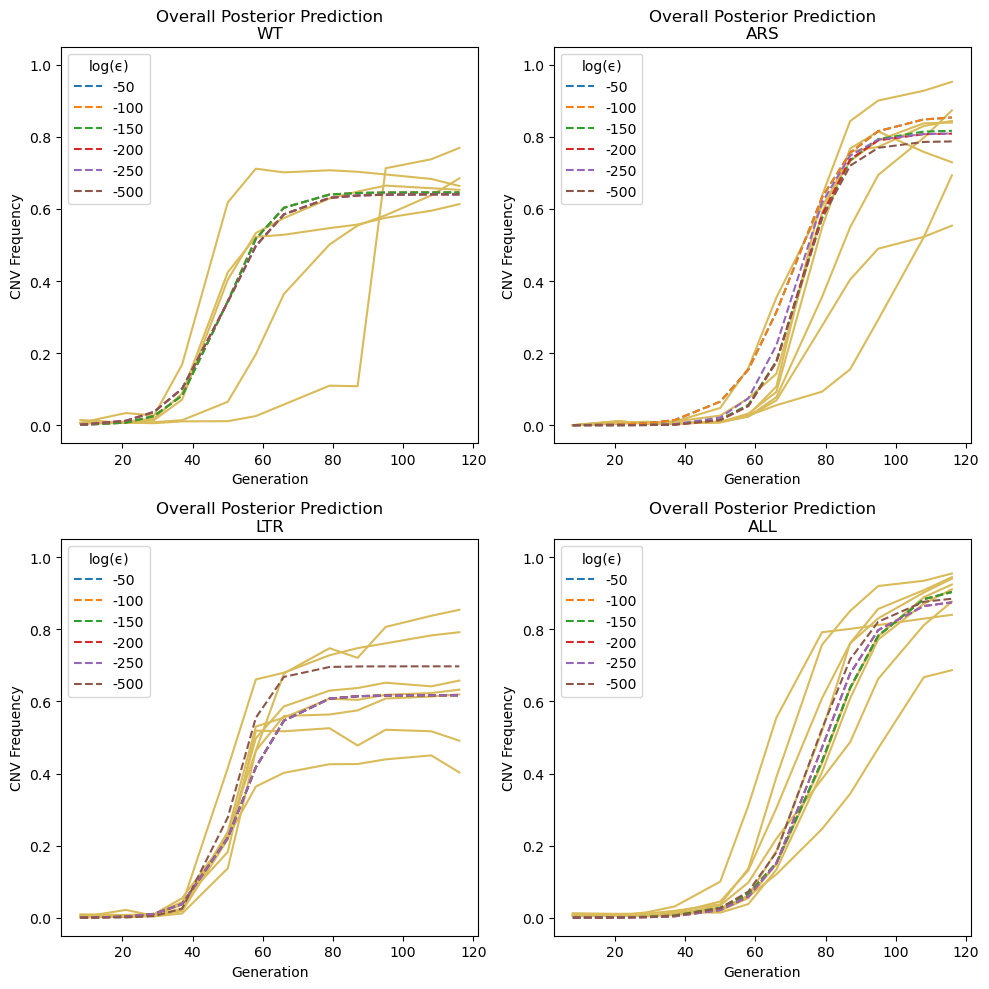

In [3]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF


prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))

posterior = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))

# Model (simulator)
reps = 1
generation = pd.read_csv('Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 3.3e8

def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
    return states
fig, ax = plt.subplots(2,2, figsize=(10,10), tight_layout=True)
def plot_epsilons(ax, line):
# Plot Overall Posterior prediction for WT
# Get data
    wt_df = pd.read_csv(f'empirical_data/clean/{line}.csv', index_col=0)
    for i in range(len(wt_df)):
        ax.plot(generation.tolist(), wt_df.iloc[i,:], color="#D9BB59")

    # Overall MAP
    for ϵ in [-50,-100,-150,-200,-250,-500]:
        prod_df = get_overall_posterior(prior,posterior,line,100,ϵ)
        overall_map = prod_df.iloc[prod_df['log_overall_posterior'].idxmax(), 0:3]
        print(overall_map)
        params = torch.tensor(list(overall_map), dtype=torch.float64)
        x = CNVsimulator(params).T
        ax.plot(generation.tolist(),x, label = ϵ, linestyle='--')

    # Plotting
    ax.legend(title = 'log(ϵ)')
    ax.set_title(f'Overall Posterior Prediction\n{line.upper()}')

    ax.set_xlabel('Generation')
    ax.set_ylabel('CNV Frequency')
    ax.set_ylim(-0.05,1.05)

plot_epsilons(ax[0,0], 'wt')
plot_epsilons(ax[1,0], 'ltr')
plot_epsilons(ax[0,1], 'ars')
plot_epsilons(ax[1,1], 'all')
plt.show()

# Validate overall posterior with sampling

In [3]:
# Get normalizing constant of posterior
lines = ['wt','ltr','ars','all']
log_Cs = {}
for line in lines:
    prod_df = pd.read_csv(f'overall_posteriors/{line}_overall_posterior.csv', index_col=0)
    log_C = -1*logsumexp(prod_df['adj_sum_logs'])
    log_Cs[line] = log_C
    
log_Cs['all']

1402.8837813033845

In [54]:
# Prior and amortized posterior
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))

posterior = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))

# Sampling from density function
def overall_posterior_log_prob(prior, posterior, log_Cs,line, theta, ϵ):
    x = pd.read_csv(f'empirical_data/clean/{line}.csv', index_col=0)
    r = len(x)
    
    potential_fn = posterior.potential_fn
    potential_fn.set_x(x.iloc[0,:])
    posterior_mcmc = MCMCPosterior(potential_fn, proposal = prior)
    
    log_probs = [max(ϵ,float(posterior_mcmc.set_default_x(x.iloc[i,:]).potential(theta))) for i in range(len(x))]
    lens = np.array([float(prior.base_dist.high[i])-float(prior.base_dist.low[i]) for i in range(3)]) # Prior dimensions
    A = np.prod(lens) # Prior volume
    return np.array(log_probs).sum() + log_Cs[line] + np.log((1/A)**(1-r))

theta = torch.tensor([-0.749,-5.99,-5.812],dtype=torch.float32)
overall_posterior_log_prob(prior, posterior, log_Cs, 'ars', theta, -250)

11.778167959789759

In [ ]:
# Sample with posterior using rejection sampling
def sample_with_posterior(prior, overall_posterior_log_prob, n_attempt):
    samples = []
    params = prior.sample((n_attempt,))
    rand = np.random.random(n_attempt)
    for i in range(n_attempt):
        theta = params[i,:]
        if np.log(rand[i]) <= overall_posterior_log_prob(prior, posterior, log_Cs, 'ars', theta, -250):
            samples.append(theta)
    return samples
sample_with_posterior(prior, overall_posterior_log_prob, 100000)